<a href="https://colab.research.google.com/github/mahdiSheykhiGithub/IMDB-Reviews-NLP/blob/main/GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries and Load data

In [103]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Dense, Dropout, GRU
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report, confusion_matrix

In [104]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/IMDB Reviews/IMDB Dataset.csv')
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


# Preprocessing

In [105]:
def text_cleaner(text):
  # HTML to text format
  soup = BeautifulSoup(text)
  text = soup.get_text()
  return text

In [106]:
data['reveiw'] = data['review'].apply(text_cleaner)

<ipython-input-105-8d42f8a4318a>:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text)


In [107]:
enc = LabelEncoder()
y = enc.fit_transform(data['sentiment'])

In [108]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['reveiw'])

In [109]:
encoded = tokenizer.texts_to_sequences(data['review'])

In [110]:
len(encoded[1])

164

In [111]:
list_len = []
for seq in encoded:
  list_len.append(len(seq))

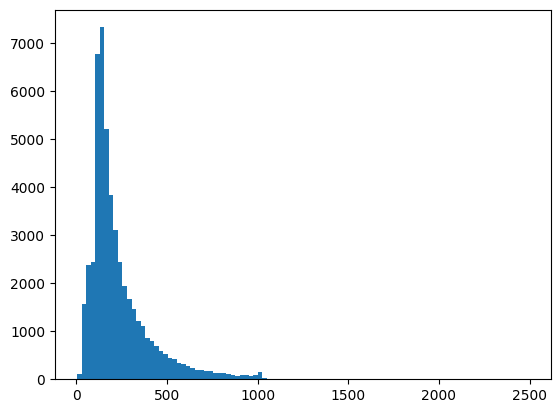

#####################################
mean of tokens 235.0299
median of tokens 176.0


In [112]:
plt.hist(list_len, bins=100)
plt.show()
print('#####################################')
print(f'mean of tokens {np.average(list_len)}')
print(f'median of tokens {np.median(list_len)}')

In [113]:
max_len = 200

In [114]:
X = pad_sequences(encoded, maxlen=max_len, padding='post')

In [115]:
X.shape

(50000, 200)

In [116]:
vocab_len = len(tokenizer.word_index) + 1
vocab_len

126507

In [117]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modeling


In [151]:
reg_e = tf.keras.regularizers.l2(0.001)

model = Sequential()
model.add(Embedding(input_dim=vocab_len, output_dim=50, input_length=max_len, embeddings_regularizer=reg_e))
model.add(GRU(units=128, activation='tanh', recurrent_dropout=0.5, dropout=0.5))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [152]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, 200, 50)           6325350   
                                                                 
 gru_15 (GRU)                (None, 128)               69120     
                                                                 
 dropout_24 (Dropout)        (None, 128)               0         
                                                                 
 dense_30 (Dense)            (None, 64)                8256      
                                                                 
 dropout_25 (Dropout)        (None, 64)                0         
                                                                 
 dense_31 (Dense)            (None, 1)                 65        
                                                                 
Total params: 6402791 (24.42 MB)
Trainable params: 64

In [153]:
opt = tf.optimizers.Adam(learning_rate=0.0001)
loss = tf.losses.BinaryCrossentropy()
metric = tf.metrics.BinaryAccuracy()
model.compile(optimizer=opt, loss=loss, metrics=metric)

In [154]:
model.fit(X_train, y_train, batch_size=50, epochs=7, validation_split=0.2, verbose=2)

Epoch 1/7
640/640 - 317s - loss: 1.9480 - binary_accuracy: 0.5042 - val_loss: 0.7425 - val_binary_accuracy: 0.5151 - 317s/epoch - 496ms/step
Epoch 2/7
640/640 - 310s - loss: 0.7030 - binary_accuracy: 0.5206 - val_loss: 0.6933 - val_binary_accuracy: 0.5315 - 310s/epoch - 484ms/step
Epoch 3/7
640/640 - 312s - loss: 0.6830 - binary_accuracy: 0.5622 - val_loss: 0.5803 - val_binary_accuracy: 0.7088 - 312s/epoch - 487ms/step
Epoch 4/7
640/640 - 314s - loss: 0.4362 - binary_accuracy: 0.8295 - val_loss: 0.3224 - val_binary_accuracy: 0.8785 - 314s/epoch - 490ms/step
Epoch 5/7
640/640 - 316s - loss: 0.3413 - binary_accuracy: 0.8875 - val_loss: 0.3165 - val_binary_accuracy: 0.8831 - 316s/epoch - 494ms/step
Epoch 6/7
640/640 - 314s - loss: 0.3010 - binary_accuracy: 0.9065 - val_loss: 0.3074 - val_binary_accuracy: 0.8866 - 314s/epoch - 491ms/step
Epoch 7/7
640/640 - 316s - loss: 0.2783 - binary_accuracy: 0.9187 - val_loss: 0.3281 - val_binary_accuracy: 0.8827 - 316s/epoch - 493ms/step


# evaluation

In [155]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 32s 97ms/step - loss: 0.3132 - binary_accuracy: 0.8864


[0.3132033050060272, 0.8863999843597412]

In [156]:
y_pred = model.predict(X_test)

313/313 [==============================] - 17s 52ms/step


In [157]:
y_pred = np.round(y_pred)

In [158]:
print(classification_report(y_test, y_pred, target_names=['negative', 'positive']))

              precision    recall  f1-score   support

    negative       0.86      0.92      0.89      4961
    positive       0.91      0.86      0.88      5039

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



In [159]:
print(confusion_matrix(y_test, y_pred))

[[4545  416]
 [ 720 4319]]
